# Experimenting on the Abalone dataset with Amazon SageMaker XGBoost Algorithm

<div style="text-align:center">
    <img src="https://raw.githubusercontent.com/SofianHamiti/amazon-sagemaker-abalone-experiments/main/media/manual.png" width="600"/>
</div>

Amazon SageMaker Experiments is a capability of Amazon SageMaker that lets you **organize, track, compare, and evaluate your machine learning experiments**.

Machine learning is an iterative process. You need to experiment with multiple combinations of data, algorithm and parameters, all the while observing the impact of incremental changes on model accuracy. Over time this iterative experimentation can result in thousands of model training runs and model versions. This makes it hard to track the best performing models and their input configurations. It’s also difficult to compare active experiments with past experiments to identify opportunities for further incremental improvements.

SageMaker Experiments **automatically tracks the inputs, parameters, configurations, and results of your iterations as trials. You can assign, group, and organize these trials into experiments**. SageMaker Experiments is integrated with Amazon SageMaker Studio providing a visual interface to browse your active and past experiments, compare trials on key performance metrics, and identify the best performing models.

Because SageMaker Experiments enables tracking of all the steps and artifacts that went into creating a model, you can quickly revisit the origins of a model when you are troubleshooting issues in production, or auditing your models for compliance verifications.

SageMaker Experiments comes with its own Experiments Python SDK which makes the analytics capabilities easily accessible in Amazon SageMaker Notebooks. You can install this by running `pip install sagemaker-experiments`. 

In this notebook, we will run a few training jobs with the XGBoost Estimator built-in into Amazon SageMaker and track some of its metrics via SageMaker Experiments. Note that in this notebook we only focus on Training and Tuning jobs, however SM Experiments is also compatible with pre-processing jobs via SageMaker Processing, batch inferences with SageMaker Batch Transform, and pipelines built with SageMaker Pipelines.

Let's set-up the dependendencies that we will need throughout the notebook and some useful SageMaker helper function and variables.

In [ ]:
!pip install -qU sagemaker>=2.37.0
!pip install -qU sagemaker-experiments>=0.1.24

If you've run the above cell in a SageMaker Notebook, please reload the kernel, then advance to the next cell.

In [1]:
import boto3
import io
import numpy as np
import os
import pandas as pd
import sagemaker
import time
import zipfile
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-inference-script-mode'

Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket and preprocess it. If you want to know more about the preprocessing, check the [xgboost direct marketing notebook](./xgboost_direct_marketing.ipynb).

In [4]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip -O /tmp/bank-additional.zip

with zipfile.ZipFile('/tmp/bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/')
    
# Load the data into a DataFrame
data = pd.read_csv('/tmp/bank-additional/bank-additional-full.csv')
# Run some preprocessing
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
# Train / test/ validation split
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
# Locally save the data
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('/tmp/train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('/tmp/validation.csv', index=False, header=False)

print('Train and validation files written locally.')

--2021-09-17 10:10:47--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.92.131.2
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.92.131.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘/tmp/bank-additional.zip’

/tmp/bank-additiona 100%[===================>] 422.68K   839KB/s    in 0.5s    

2021-09-17 10:10:48 (839 KB/s) - ‘/tmp/bank-additional.zip’ saved [432828/432828]

Train and validation files written locally.


In [5]:
sagemaker_session = sagemaker.Session()

train_path = sagemaker_session.upload_data('/tmp/train.csv', bucket=bucket, key_prefix=os.path.join(prefix, 'train/train.csv'))
validation_path = sagemaker_session.upload_data('/tmp/validation.csv', bucket=bucket, key_prefix=os.path.join(prefix, 'validation/train.csv'))

train_input = TrainingInput(train_path, content_type='text/csv')
validation_input = TrainingInput(validation_path, content_type='text/csv')

data_inputs = {
    'train': train_input,
    'validation': validation_input
}

### Amazon SageMaker Experiments: features

Amazon SageMaker Experiments offers a structured organization scheme to help users group and organize their machine learning iterations. The top level entity, an **experiment**, is a collection of **trials** that are observed, compared, and evaluated as a group. A trial is a set of steps called **trial components**. Each trial component can include a combination of inputs such as datasets, algorithms, and parameters, and produce specific outputs such as models, metrics, datasets, and checkpoints. Examples of trial components are data pre-processing jobs, training jobs, and batch transform jobs.

The goal of an experiment is to determine the trial that produces the best model. Multiple trials are performed, each one isolating and measuring the impact of a change to one or more inputs, while keeping the remaining inputs constant. By analyzing the trials, you can determine which features have the most effect on the model.

Let's start by creating an experiment.

In [6]:
example_experiment = Experiment.create(
    experiment_name=f"direct-marketing-{int(time.time())}", 
    description="Using SM Experiments with the Direct Marketing dataset."
)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fd563ac61d0>,experiment_name='direct-marketing-1631873624',description='Using SM Experiments with the Direct Marketing dataset.',tags=None,experiment_arn='arn:aws:sagemaker:eu-west-1:859755744029:experiment/direct-marketing-1631873624',response_metadata={'RequestId': '86a56632-0718-4a94-b350-1aff4e763f03', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '86a56632-0718-4a94-b350-1aff4e763f03', 'content-type': 'application/x-amz-json-1.1', 'content-length': '99', 'date': 'Fri, 17 Sep 2021 10:13:43 GMT'}, 'RetryAttempts': 0})


The experiment that we've just created can also be visualized in the SageMaker Resources tab of SageMaker Studio. Just click on the SageMaker Resources button on the left, look for "SageMaker Experiments and trials" in the drop-down menu, and double-click on the `direct-marketing-XXXXXXXXXX` experiment. Since we have not created a trial yet, nothing will populate this menu for now. However, you can also check the *`Unassigned trial components`* which should be populated by the previous processing or training jobs you've run in the current account.

### SageMaker Experiments: Trials and Training job

Let's start simple and launch a training job for our XGBoost model. SageMaker will automatically create a **`Trial`** for us, or we can choose to create one ourselves to give it a name of our choice. To create a new Trial, its name must be unique to the current account. A Trial is also bound to a specific Experiment, which we've already created before.

In [7]:
trial_name = f"direct-marketing-xgboost-{int(time.time())}"
trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=example_experiment.experiment_name
)

We can now refresh on the left the Experiments and trial SageMaker Resource tab, to see that a new Trial has been created. We can now directly train our XGBoost model and track it with SM Experiments and the Trial we have just created. To learn more about training, check out the [xgboost direct marketing notebook](./xgboost-direct-marketing.ipynb). What's different from the basic SageMaker training is that in the `fit()` call we actually provide an `experiment_config` value, which bounds the training job to the the Trial. 

In [8]:
# Retrieve the container image
container = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name, 
    framework='xgboost', 
    version='latest'
)
# Set-up the estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker_session
)
# Set the hyperparameters
xgb.set_hyperparameters(
    max_depth=5, eta=0.2, gamma=4, min_child_weight=6,
    subsample=0.8, silent=0, objective='binary:logistic', num_round=100
)

xgb.fit(
    inputs = data_inputs,
    experiment_config={
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": "DirectMarketingTrainingXGBoost", # If not provided, SageMaker creates one automatically
    }
) 

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-2021-09-17-10-29-12-551


2021-09-17 10:29:12 Starting - Starting the training job...
2021-09-17 10:29:36 Starting - Launching requested ML instancesProfilerReport-1631874552: InProgress
......
2021-09-17 10:30:36 Starting - Preparing the instances for training.........
2021-09-17 10:32:01 Downloading - Downloading input data
2021-09-17 10:32:01 Training - Downloading the training image..Arguments: train
[2021-09-17:10:32:17:INFO] Running standalone xgboost training.
[2021-09-17:10:32:17:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8044.43mb
[2021-09-17:10:32:17:INFO] Determined delimiter of CSV input is ','
[10:32:17] S3DistributionType set as FullyReplicated
[10:32:17] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-09-17:10:32:17:INFO] Determined delimiter of CSV input is ','
[10:32:17] S3DistributionType set as FullyReplicated
[10:32:17] 8238x59 matrix with 486042 entries loaded from /opt/ml

While the model is training, we can go to the "SageMaker Experiments and trial" tab and double-click on the Trial name. There should now be a `DirectMarketingTrainingXGBoost` *Trial component*, which we can double click to further investigate all experiment artifacts including datasets, algorithms, hyperparameters, and model metrics that are being tracked and recorded. This data allows you to trace the complete lineage of a model which helps with model governance, auditing, and compliance verifications.

SageMaker Experiments also automatically tracks Amazon SageMaker Autopilot jobs as experiments with their underlying training jobs tracked as trials. You can check how to use SageMaker Autopilot in the [related notebook](sagemaker_autopilot_direct_marketing.ipynb) .

Once the training job is completed, you can check the output metrics of the models directly in the SageMaker Experiments interface:

![sm-experiment-one-training-metrics.png](./images/sm-experiment-one-training-metrics.png)

Let's take things a step further and create an HPO job.

In [13]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Setup the hyperparameter ranges
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}
# Define the target metric and the objective type (max/min)
objective_metric_name = 'validation:auc'
objective_type='Maximize'
# Define the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    objective_type = objective_type,
    max_jobs=12,
    max_parallel_jobs=4,
    early_stopping_type='Auto'
)
# Launch the HPO job! 
tuner.fit(
    inputs = data_inputs,
    job_name = 'DirectMarketing-HPO-XGBoost'
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: DirectMarketing-HPO-XGBoost


...................................................................................................................................!


At the moment of writing this notebook, SageMaker Tuning jobs do not support the `experiment_config` parameter, therefore do not log automatically new trial components to SageMaker Experiments. We can perform this operation manually instead. We need to search for the Trial Components that contain the `job_name` we've given to the HPO job previously, and tadd them to our existing trial.

In [17]:
tuner.latest_tuning_job.job_name

'DirectMarketing-HPO-XGBoost'

In [26]:
from smexperiments.search_expression import Filter, Operator, SearchExpression
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent

# Create a new Trial just for HPO XGBoost
trial_name = f"{tuner.latest_tuning_job.job_name}-{int(time.time())}"
trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=example_experiment.experiment_name
)

# Define the search expression: we're looking for
# trial components that contain 'DirectMarketing-HPO-XGBoost'
search_expression = SearchExpression(
    filters=[
        Filter('TrialComponentName', Operator.CONTAINS, tuner.latest_tuning_job.job_name),
    ],
)

# Let's look for them and add them to our previously created trial
trial_component_search_results = TrialComponent.search(search_expression=search_expression)
for tc in trial_component_search_results:
    trial.add_trial_component(tc.trial_component_name)
    time.sleep(0.5)  # sleep to avoid throttling


### SageMaker Experiments: Analyze experiment results

Let's now visualize the results that we've obtained. We can either do this via the SageMaker Experiments and Trials tab, or we can create our own dataframe and plot it according to our preferences.

In [39]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=example_experiment.experiment_name,
    search_expression={"Filters":search_expression.filters},
    metric_names=['ObjectiveMetric']
)
df = trial_component_analytics.dataframe()
df.head()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,eta,...,ObjectiveMetric - Last,ObjectiveMetric - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,DirectMarketing-HPO-XGBoost-011-839130fe-aws-t...,DirectMarketing-HPO-XGBoost-011-839130fe-aws-t...,arn:aws:sagemaker:eu-west-1:859755744029:train...,685385470294.dkr.ecr.eu-west-1.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.092759,0.128185,...,0.776408,0,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,None,s3://sagemaker-eu-west-1-859755744029/sagemake...,[direct-marketing-xgboost-1631874210],[direct-marketing-1631873624]
1,DirectMarketing-HPO-XGBoost-012-34ee7996-aws-t...,DirectMarketing-HPO-XGBoost-012-34ee7996-aws-t...,arn:aws:sagemaker:eu-west-1:859755744029:train...,685385470294.dkr.ecr.eu-west-1.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,1.964219,0.066986,...,0.778498,0,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,None,s3://sagemaker-eu-west-1-859755744029/sagemake...,[direct-marketing-xgboost-1631874210],[direct-marketing-1631873624]
2,DirectMarketing-HPO-XGBoost-010-a0eb1970-aws-t...,DirectMarketing-HPO-XGBoost-010-a0eb1970-aws-t...,arn:aws:sagemaker:eu-west-1:859755744029:train...,685385470294.dkr.ecr.eu-west-1.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,1.602547,0.382751,...,0.775638,0,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,None,s3://sagemaker-eu-west-1-859755744029/sagemake...,[direct-marketing-xgboost-1631874210],[direct-marketing-1631873624]
3,DirectMarketing-HPO-XGBoost-009-5cac11a0-aws-t...,DirectMarketing-HPO-XGBoost-009-5cac11a0-aws-t...,arn:aws:sagemaker:eu-west-1:859755744029:train...,685385470294.dkr.ecr.eu-west-1.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,1.541329,0.096733,...,0.775508,0,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,None,s3://sagemaker-eu-west-1-859755744029/sagemake...,[direct-marketing-xgboost-1631874210],[direct-marketing-1631873624]
4,DirectMarketing-HPO-XGBoost-008-d55d9535-aws-t...,DirectMarketing-HPO-XGBoost-008-d55d9535-aws-t...,arn:aws:sagemaker:eu-west-1:859755744029:train...,685385470294.dkr.ecr.eu-west-1.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,1.417466,0.198761,...,0.762613,0,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,text/csv,s3://sagemaker-eu-west-1-859755744029/sagemake...,None,s3://sagemaker-eu-west-1-859755744029/sagemake...,[direct-marketing-xgboost-1631874210],[direct-marketing-1631873624]


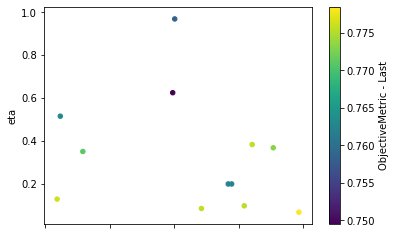

In [59]:
df.plot.scatter(x='alpha', y='eta', c='ObjectiveMetric - Last', colormap='viridis')

### SageMaker Experiments: Advanced usage

SageMaker Experiments is not just automatic tracking on inputs, parameters, metrics and outputs. It is also possible to use a `smexperiments.tracker.Tracker` object before calling the `fit()` operation to manually record experiment information to a SageMaker trial component:

- record one or more parameters with `log_parameter` or `log_parameters`
- record one or more input artifacts for this trial component with `log_input` or `log_inputs`
- record one or more output artifacts for this trial component with `log_output` or `log_outputs`

If you're using your own custom script / container, you can also use SageMaker Experiments to log metrics and other information from within your training loop. You just need to load a `Tracker` and then call the `log_metric` function. 

```python
[...]
from smexperiments.tracker import Tracker
with Tracker.load() as tracker:
    [...]
    for epoch in range(epochs):
        # your training logic and calculate accuracy and loss
        my_tracker.log_metric(metric_name='accuracy', value=0.9, iteration_number=epoch)
        my_tracker.log_metric(metric_name='loss', value=0.03, iteration_number=epoch)
```

Note that metrics logged with this method will only appear in SageMaker when this method is called from a training job host. Learn more at the [SM Experiments documentation](https://sagemaker-experiments.readthedocs.io/en/latest/tracker.html#smexperiments.tracker.Tracker.log_metric).